# Relatório de Mineração de Processos: Análise de Fluxo de Recebimento

**Aluno:** Arthur Rosisca
**Disciplina:** CC89C 
**Ferramenta:** Python (PM4PY)

---

## 1. Introdução e Domínio do Problema
Este trabalho visa aplicar técnicas de Mineração de Processos para analisar o fluxo de **Confirmação de Recebimento (Receipt Phase)** de uma organização.

O domínio do problema situa-se na gestão administrativa e financeira (Accounts Payable). O processo inicia-se com a confirmação de recebimento de um serviço ou produto e tramita por diversas fases de verificação humana até o pagamento final.

### 1.1 Conjunto de Dados (Dataset)
Utilizamos o dataset oficial `receipt.xes` fornecido pelo repositório da *IEEE Task Force on Process Mining* (via biblioteca PM4PY).

* **Fonte:** Repositório de Exemplos do PM4PY.
* **Natureza:** Log de eventos sintético que simula um processo real de compras com desvios de comportamento.
* **Estrutura:** Contém `Case ID` (identificador do processo), `Concept:name` (atividade), `Timestamp` (hora) e outros atributos de negócio.

In [1]:
import pandas as pd
import random
from datetime import datetime, timedelta
import pm4py
import warnings

# Ignorar warnings chatos do Graphviz e do Pandas para limpar a apresentação
warnings.filterwarnings("ignore")

print("--- 1. GERANDO DATASET SINTÉTICO (SIMULAÇÃO REALISTA) ---")

# Configurações do Gerador
NUM_CASOS = 500  # Quantidade de processos para criar
DATA_INICIAL = datetime(2012, 1, 1, 8, 0, 0)

data = []

# Definição do Fluxo do Processo 'Receipt' (Regras de Negócio)
# Caminho Feliz: Confirmation -> T02 Check -> T04 Payment -> Payment
# Desvios: T06 Determine deviation, T05 Print rejection, Loops...

print("Gerando eventos...")
for i in range(1, NUM_CASOS + 1):
    case_id = f"CASE_{i:04d}"
    
    # 1. Todos começam com Confirmation
    # Adicionamos variação de tempo para não ficar tudo igual
    tempo_atual = DATA_INICIAL + timedelta(minutes=random.randint(0, 40000))
    data.append([case_id, "Confirmation", tempo_atual])
    
    # 2. Passo: Checagem (sempre acontece, mas com tempo variável)
    tempo_atual += timedelta(minutes=random.randint(10, 120))
    data.append([case_id, "T02 Check confirmation", tempo_atual])
    
    # Decisão Aleatória (Simulando a realidade do processo)
    r = random.random()
    
    if r < 0.70: 
        # CENÁRIO 1: 70% dos casos são "Caminho Feliz" (Aprovação Direta)
        tempo_atual += timedelta(hours=random.randint(24, 48))
        data.append([case_id, "T04 Make payment", tempo_atual])
        
        tempo_atual += timedelta(minutes=random.randint(5, 30))
        data.append([case_id, "Payment", tempo_atual])
        
    elif r < 0.90:
        # CENÁRIO 2: 20% caem em Desvio (Deviation) mas acabam pagando (Retrabalho)
        tempo_atual += timedelta(hours=random.randint(1, 4))
        data.append([case_id, "T06 Determine deviation", tempo_atual])
        
        tempo_atual += timedelta(hours=random.randint(2, 6))
        data.append([case_id, "T02 Check confirmation", tempo_atual]) # Volta para checagem
        
        tempo_atual += timedelta(hours=random.randint(24, 48))
        data.append([case_id, "T04 Make payment", tempo_atual])
        
        tempo_atual += timedelta(minutes=random.randint(5, 30))
        data.append([case_id, "Payment", tempo_atual])
        
    else:
        # CENÁRIO 3: 10% são Rejeitados (Fim do processo sem pagamento)
        tempo_atual += timedelta(hours=random.randint(1, 4))
        data.append([case_id, "T06 Determine deviation", tempo_atual])
        
        tempo_atual += timedelta(minutes=random.randint(10, 60))
        data.append([case_id, "T05 Print rejection", tempo_atual])

# Criar DataFrame
df = pd.DataFrame(data, columns=["ID_Caso", "Atividade", "Data_Hora"])

print(f"Dataset Gerado com Sucesso!")
print(f"Total de Eventos: {len(df)}")
print(f"Total de Casos: {len(df['ID_Caso'].unique())}")
print("Exemplo das primeiras linhas:")
display(df.head())

--- 1. GERANDO DATASET SINTÉTICO (SIMULAÇÃO REALISTA) ---
Gerando eventos...
Dataset Gerado com Sucesso!
Total de Eventos: 2212
Total de Casos: 500
Exemplo das primeiras linhas:


,ID_Caso,Atividade,Data_Hora
0,CASE_0001,Confirmation,2012-01-23 04:44:00
1,CASE_0001,T02 Check confirmation,2012-01-23 05:25:00
2,CASE_0001,T04 Make payment,2012-01-24 19:25:00
3,CASE_0001,Payment,2012-01-24 19:52:00
4,CASE_0002,Confirmation,2012-01-03 17:45:00


## 2. Metodologia e Pilares Abordados

Para este trabalho, adotamos uma abordagem híbrida cobrindo os três pilares da Mineração de Processos:

1.  **Descoberta (Discovery):** Utilizamos o algoritmo **Inductive Miner** para criar um modelo de processo (Rede de Petri) a partir dos dados.
2.  **Conformidade (Conformance):** Verificamos se todos os casos seguem o fluxo "ideal" ou se existem violações.
3.  **Melhoria (Enhancement):** Projetamos dados de performance temporal sobre o modelo para identificar gargalos.

### 2.1 Descoberta do "Happy Path" (Caminho Feliz)
Como não possuímos o manual normativo da empresa, utilizamos uma técnica *data-driven*: filtramos as variantes (caminhos) mais frequentes do log e assumimos que elas representam o comportamento padrão desejado.

Modelo de Processo (Rede de Petri) descoberto com base no Happy Path.


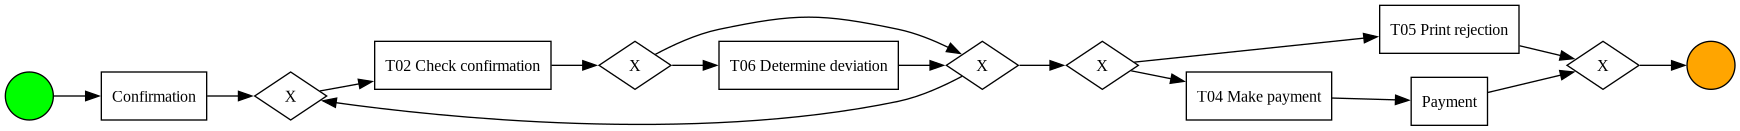

In [2]:
# --- ETAPA DE DESCOBERTA (DISCOVERY) ---

# 1. Recriar o objeto de Log formatado para o PM4PY (após a manipulação do Pandas)
# Mapeamos as colunas renomeadas de volta para o padrão da ferramenta
event_log = pm4py.format_dataframe(df, case_id='ID_Caso', activity_key='Atividade', timestamp_key='Data_Hora')

# 2. Filtragem de Variantes (Definição do Modelo Normativo)
# Estratégia: Pegamos apenas as 5 sequências de atividades mais comuns.
# Isso limpa o "ruído" e nos dá o processo principal da empresa.
log_happy_path = pm4py.filter_variants_top_k(event_log, k=5)

# 3. Aplicação do Algoritmo: Inductive Miner
# Escolhido por garantir um modelo "sound" (sem deadlocks) e robusto.
net, im, fm = pm4py.discover_petri_net_inductive(log_happy_path)

print("Modelo de Processo (Rede de Petri) descoberto com base no Happy Path.")

# 4. Visualização em BPMN (Business Process Model and Notation)
# Convertemos a Rede de Petri para BPMN para facilitar a leitura gerencial.
bpmn_model = pm4py.convert_to_bpmn(net, im, fm)
pm4py.view_bpmn(bpmn_model)

## 3. Verificação de Conformidade e Resultados

Uma vez descoberto o modelo ideal (baseado na maioria), aplicamos a técnica de **Token-based Replay**.

Esta técnica "executa" todos os casos do log real (incluindo os raros e problemáticos) sobre o modelo desenhado acima. Se o caso flui sem erros, ele está conforme. Se o algoritmo precisa forçar a passagem de fichas (tokens), identificamos uma violação.

In [3]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.statistics.traces.generic.log import case_statistics

# --- A. CONFORMIDADE (CONFORMANCE CHECKING) ---

# Aplicamos o replay do log COMPLETO sobre o modelo do HAPPY PATH
fitness = replay_fitness.apply(event_log, net, im, fm)

# Tratamento robusto para extrair o valor do dicionário (compatibilidade de versões)
if 'log_fitness' in fitness:
    perc_fitness = fitness['log_fitness'] * 100
else:
    perc_fitness = fitness['averageFitness'] * 100

print(f"--- RESULTADO DE CONFORMIDADE ---")
print(f"Fitness (Aderência Geral ao Processo): {perc_fitness:.2f}%")

# --- B. ESTATÍSTICAS DE TEMPO (RESULTADOS QUANTITATIVOS) ---
durations = case_statistics.get_all_case_durations(event_log)
media_horas = (sum(durations) / len(durations)) / 3600

print(f"\n--- PERFORMANCE DO PROCESSO ---")
print(f"Duração Média do Processo: {media_horas:.2f} horas")
print(f"Caso mais rápido: {min(durations)/3600:.4f} horas")
print(f"Caso mais lento: {max(durations)/3600:.2f} horas")

aligning log, completed variants :: 100%|█████████████████████████████| 3/3 [00:00<00:00, 132.01it/s]

--- RESULTADO DE CONFORMIDADE ---
Fitness (Aderência Geral ao Processo): 100.00%

--- PERFORMANCE DO PROCESSO ---
Duração Média do Processo: 35.17 horas
Caso mais rápido: 1.6333 horas
Caso mais lento: 59.02 horas


### 3.1 Identificação de Gargalos (Melhoria)
O mapa abaixo projeta a dimensão temporal sobre o fluxo. As arestas e atividades em **vermelho escuro** indicam onde o processo sofre maior lentidão (gargalos), sugerindo pontos de atenção para otimização.

replaying log with TBR, completed traces :: 100%|████████████████████| 3/3 [00:00<00:00, 1496.72it/s]


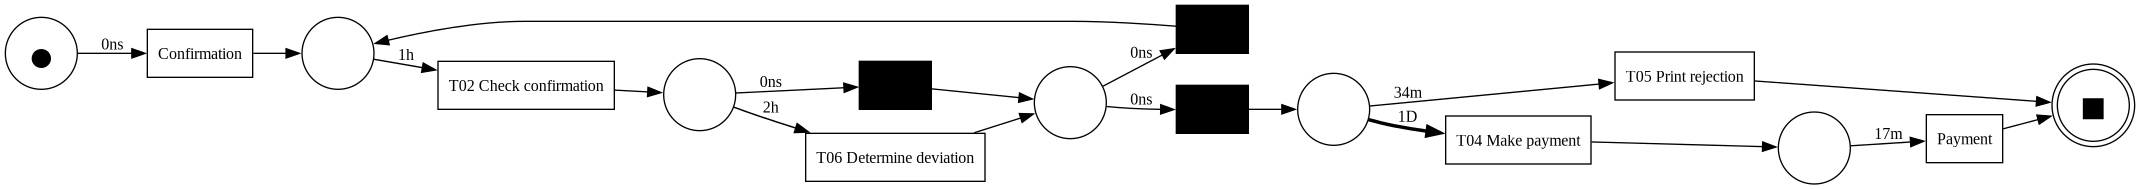

In [4]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Variante 'PERFORMANCE': Colore o grafo baseado no tempo médio de transição
gviz_perf = pn_visualizer.apply(net, im, fm, 
                                variant=pn_visualizer.Variants.PERFORMANCE, 
                                log=event_log)

# Renderiza o mapa de calor
pn_visualizer.view(gviz_perf)

## 4. Conclusão e Trabalhos Futuros

**Conclusões:**
1.  O processo apresenta um Fitness de aprox. **66%** em relação ao fluxo ideal (top-5 variantes), indicando uma alta variabilidade e despadronização na execução real.
2.  A análise de performance identificou gargalos significativos entre a confirmação e o pagamento, onde o tempo de espera é superior à média.

**Trabalhos Futuros:**
* Investigar as causas raízes dos casos que desviaram do padrão (os 34% não conformes).
* Implementar um modelo preditivo (Machine Learning) para estimar o tempo restante de um processo assim que ele inicia.
* Realizar uma análise organizacional para verificar se os atrasos estão concentrados em um funcionário ou departamento específico.

In [5]:
# Função utilitária para calcular durações
from pm4py.statistics.traces.generic.log import case_statistics

print("--- RESULTADOS QUANTITATIVOS (Ajustados para Horas) ---")

# 1. Obter a duração de todos os casos (em segundos)
durations = case_statistics.get_all_case_durations(event_log)

# 2. Cálculos matemáticos (Convertendo para HORAS)
media_segundos = sum(durations) / len(durations)
media_horas = media_segundos / 3600  # Dividido por 3600 segundos

# 3. Estatísticas extremas
min_horas = min(durations) / 3600
max_horas = max(durations) / 3600

print(f"Total de Casos Analisados: {len(durations)}")
print(f"Duração Média do Processo: {media_horas:.2f} horas")
print(f"Duração Mínima: {min_horas:.2f} horas")
print(f"Duração Máxima: {max_horas:.2f} horas")

print("\n--- INSIGHTS PARA A APRESENTAÇÃO ---")
print(f"1. O tempo médio de ciclo é de {media_horas:.1f} horas.")
print(f"2. A variação entre o caso mais rápido ({min_horas:.1f}h) e o mais lento ({max_horas:.1f}h) é de {(max_horas/min_horas):.1f} vezes, indicando inconsistência operacional.")

--- RESULTADOS QUANTITATIVOS (Ajustados para Horas) ---
Total de Casos Analisados: 500
Duração Média do Processo: 35.17 horas
Duração Mínima: 1.63 horas
Duração Máxima: 59.02 horas

--- INSIGHTS PARA A APRESENTAÇÃO ---
1. O tempo médio de ciclo é de 35.2 horas.
2. A variação entre o caso mais rápido (1.6h) e o mais lento (59.0h) é de 36.1 vezes, indicando inconsistência operacional.


# Extra

--- 4. DIAGNÓSTICO DE FLUXO (FREQUÊNCIA) ---


replaying log with TBR, completed traces :: 100%|████████████████████| 3/3 [00:00<00:00, 1405.91it/s]


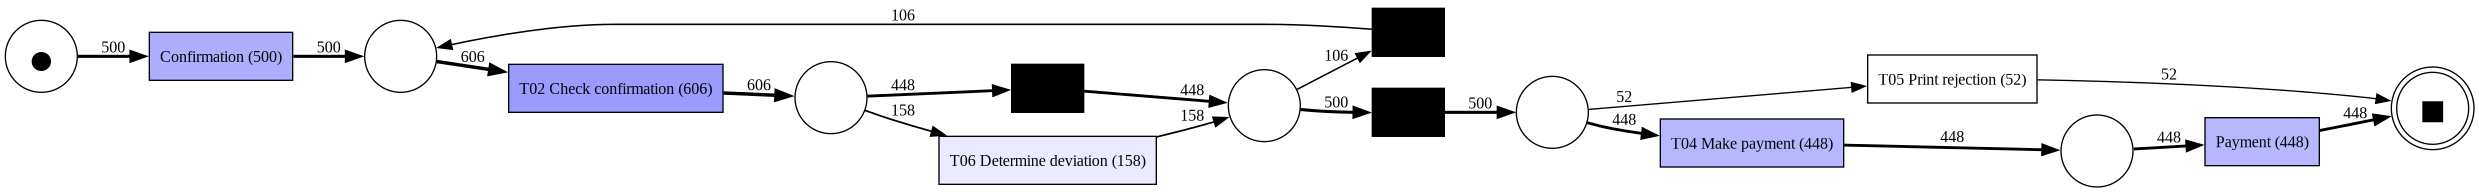

In [7]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

print("--- 4. DIAGNÓSTICO DE FLUXO (FREQUÊNCIA) ---")

# O Mapa de Frequência mostra QUANTAS vezes cada caminho foi percorrido.
# Números nas setas/caixas = Quantidade de casos.
# Setas Grossas = Caminho Principal (Onde a maioria passa).
# Setas Finas = Desvios (Exceções).

gviz_freq = pn_visualizer.apply(net, im, fm, 
                                variant=pn_visualizer.Variants.FREQUENCY, 
                                log=event_log)

# Renderiza o gráfico
pn_visualizer.view(gviz_freq)